# Read data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip '/content/gdrive/My Drive/new_images.zip' 

Streaming output truncated to the last 5000 lines.
  inflating: images/ed73c3216.jpg    
  inflating: images/a817da1df.jpg    
  inflating: images/4e2c9230d.jpg    
  inflating: images/3c79d2e28.jpg    
  inflating: images/0bd505b1b.jpg    
  inflating: images/lr8ac4ba80d.jpg  
  inflating: images/lrcbb659739.jpg  
  inflating: images/6355bcd53.jpg    
  inflating: images/2dfedfe3c.jpg    
  inflating: images/udbbde78fe1.jpg  
  inflating: images/16d9c0a30.jpg    
  inflating: images/6505eb32e.jpg    
  inflating: images/dab4aae2e.jpg    
  inflating: images/9aec868be.jpg    
  inflating: images/ude52f2f2de.jpg  
  inflating: images/097e28492.jpg    
  inflating: images/c92192495.jpg    
  inflating: images/54a1df397.jpg    
  inflating: images/6e71531ae.jpg    
  inflating: images/164ed8257.jpg    
  inflating: images/39fe944cc.jpg    
  inflating: images/a1f41023e.jpg    
  inflating: images/4729288ed.jpg    
  inflating: images/5e88c8a04.jpg    
  inflating: images/lr43d7e6da0.jpg  

In [3]:
import pandas as pd

train2 = pd.read_pickle('/content/gdrive/My Drive/train2_new')

Successfully created augmented images and their encoded pixels. train2 contains the names and the encoded pixels of all images

In [4]:
from tqdm import tqdm 

for i in tqdm(range(len(train2))):
  for j in range(1,5):
    if type(train2['e'+str(j)].iloc[i]) is not str:
      train2['e'+str(j)][i] = train2['e'+str(j)].iloc[i][0]

100%|██████████| 13377/13377 [00:03<00:00, 3576.28it/s]


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(train2, test_size=0.33, random_state=42)

# Tensorflow tf.data pipeline

In [6]:
import cv2

def masks(encoded_pixels):
    counts=[]
    mask=np.zeros((256*1600), dtype=np.int8) 
    pre_mask=np.asarray([int(point) for point in encoded_pixels.split()])
    for index,count in enumerate(pre_mask):
        if(index%2!=0):
            counts.append(count)
    i=0
    for index,pixel in enumerate(pre_mask):
        if(index%2==0):
            if(i==len(counts)):
                break
            mask[pixel:pixel+counts[i]]=1
            i+=1
    mask=np.reshape(mask,(1600,256))
    mask=cv2.resize(mask,(256,1600)).T
    return mask

from PIL import Image

def preprocess(file_path):
    # you should decode bytes type to string type
    img_name = (file_path.numpy()[0].decode('UTF-8'))
    img_name = 'images/'+img_name
    img = cv2.imread(img_name)/255
    img = cv2.resize(img,(1600,256))
    mask = np.empty((256,1600,4),dtype=np.int8)
    for i in range(4):
      mask[:,:,i] = masks(file_path.numpy()[i+1].decode('UTF-8'))
    mask = tf.convert_to_tensor(mask)
    return img,mask

In [7]:
import tensorflow as tf
import numpy as np

train_dataset = tf.data.Dataset.from_tensor_slices(X_train.values)
test_dataset = tf.data.Dataset.from_tensor_slices(X_test.values)

In [8]:
train_ds = train_dataset.map(lambda x: tf.py_function(preprocess, [x], [tf.float64,tf.int8]),num_parallel_calls=5)
test_ds = test_dataset.map(lambda x: tf.py_function(preprocess, [x], [tf.float64,tf.int8]),num_parallel_calls=5)

In [9]:
BATCH_SIZE = 10

# for reference about the BUFFER_SIZE in shuffle:
# https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle
BUFFER_SIZE = 1000

dataset = {"train": train_ds, "val": test_ds}

# -- Train Dataset --#
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=42)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

print(dataset['train'])
print(dataset['val'])


<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float64, tf.int8)>
<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float64, tf.int8)>


In [10]:
! pip uninstall keras -y
! pip install segmentation-models

Uninstalling Keras-2.4.3:
  Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 51kB 2.5MB/s 


# Model

In [11]:
# Dice similarity coefficient loss, brought to you by: https://github.com/nabsabraham/focal-tversky-unet
from tensorflow.keras import backend as K
# https://www.kaggle.com/xhlulu/severstal-simple-keras-u-net-boilerplate

# COMPETITION METRIC
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [12]:
import tensorflow as tf

tf.keras.backend.clear_session()

SM_FRAMEWORK=tf.keras
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import DiceLoss
from segmentation_models.metrics import iou_score,f1_score,Recall
import tensorflow
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, Add, Flatten
from tensorflow import reduce_sum
import numpy as np
from PIL import Image

WIDTH=1600
HEIGHT=256 

import segmentation_models as sm
network = 'resnet34'
process_input = get_preprocessing(network)

adam = tf.keras.optimizers.Adam(lr=0.01)

model = Unet(network,input_shape = (256, 1600, 3),classes=4,activation='sigmoid',encoder_freeze=True)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=[dice_coef])

Segmentation Models: using `tf.keras` framework.
85524480/85521592 [==============================] - 8s 0us/step


In [13]:
from tensorflow.keras.callbacks import Callback,ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")

callback_list=[]
%load_ext tensorboard
log_dir="Model-1-logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph
=True,write_grads=True)
callback_list.append(tensorboard_callback)

filepath="Model-Unet-weights.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=0, save_best_only=True,
mode='auto')
callback_list.append(checkpoint)

callback_list.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8,patience=1, min_lr=0.001)
callback_list.append(reduce_lr)

In [14]:
model.fit(dataset['train'],validation_data = dataset['val'],epochs = 30, callbacks=callback_list,steps_per_epoch=len(X_train)//10,validation_steps=len(X_test)//10)

Epoch 1/30
  1/896 [..............................] - ETA: 0s - loss: 0.8424 - dice_coef: 0.0431WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
896/896 [==============================] - 551s 615ms/step - loss: 0.0368 - dice_coef: 0.2812 - val_loss: 0.0573 - val_dice_coef: 0.1543
Epoch 2/30
896/896 [==============================] - 549s 613ms/step - loss: 0.0262 - dice_coef: 0.4349 - val_loss: 0.0288 - val_dice_coef: 0.4870
Epoch 3/30
896/896 [==============================] - 550s 614ms/step - loss: 0.0235 - dice_coef: 0.4824 - val_loss: 0.0221 - val_dice_coef: 0.5069
Epoch 4/30
896/896 [==============================] - 549s 613ms/step - loss: 0.0219 - dice_coef: 0.5104 - val_loss: 0.0213 - val_dice_coef: 0.5647
Epoch 5/30
896/896 [=========================

No overfit is seen

In [15]:
!cp '/content/Model-Unet-weights.hdf5' '/content/gdrive/My Drive'

# Tensorboard plot

In [ ]:
%tensorboard --logdir 'Model-1-logs'

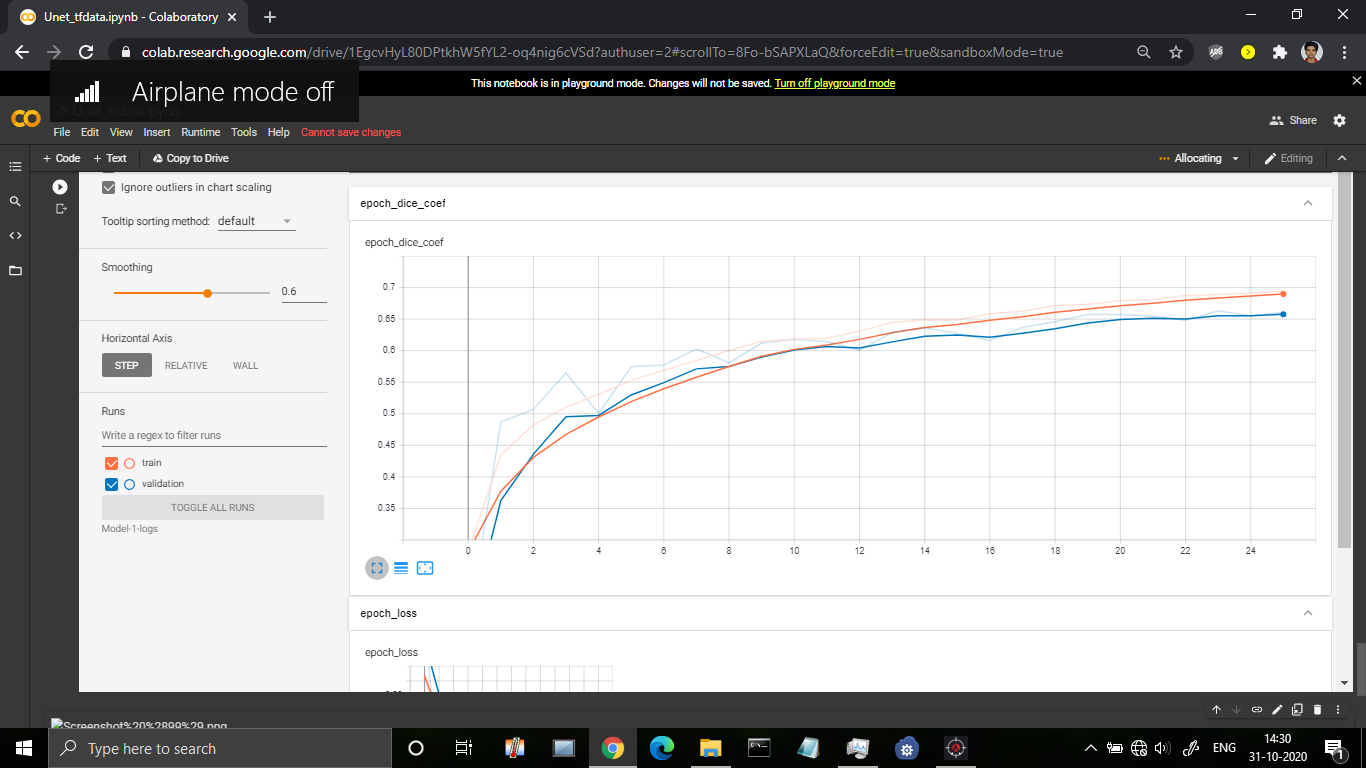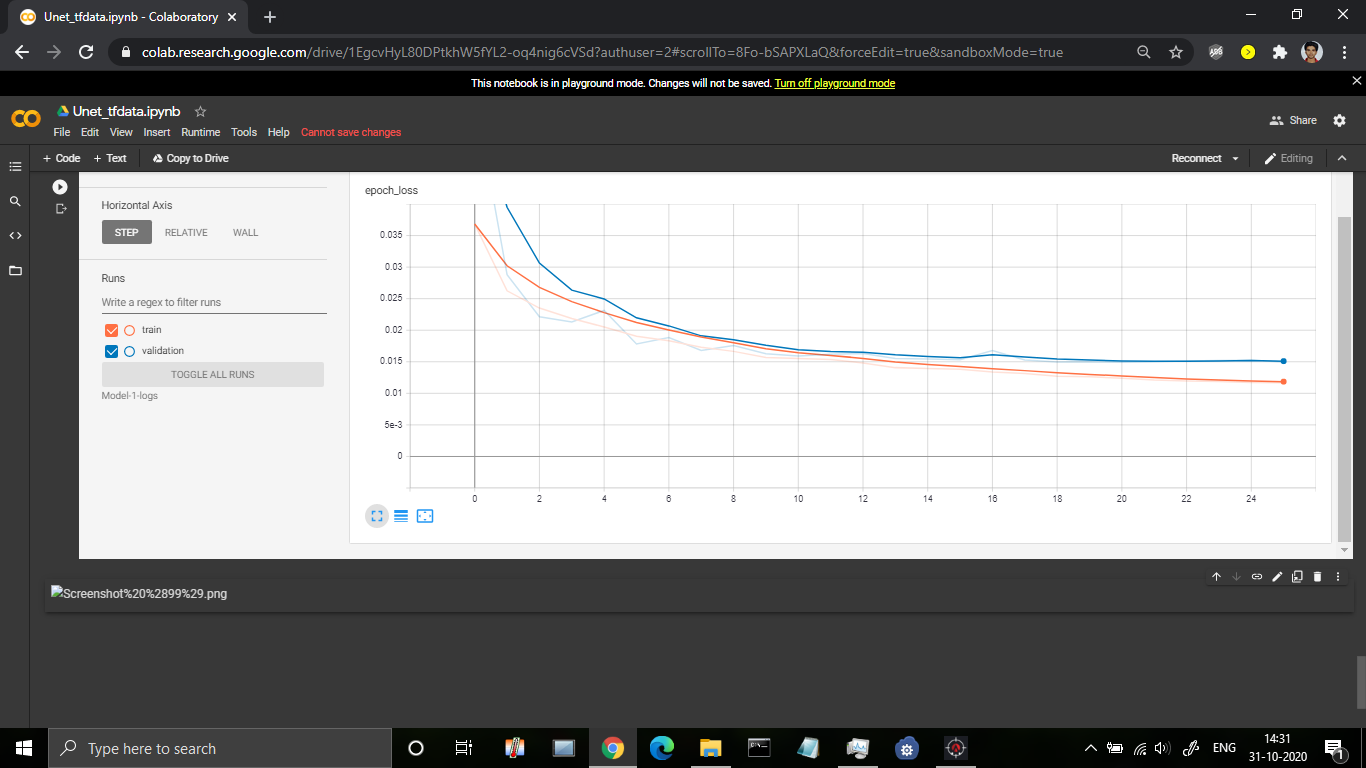